# Guide Notebook

This notebook serves as a demonstration of the main workflow of the `LISA` package. We will create some synthetic `c3d` files, process the data, and apply the machine learning algorithms to predict the activity type, speed, and incline of the data. We explore how to evaluate the models' performance, and how to apply a trained model to some new data.

## Project Description
This code was developed for an project in which several participants were fitted with inertial measurement unit (IMU) devices and performed several different actions on a laboratory treadmill. These actions were categorised as either 'walk', 'run', or 'jump'. 'Walk' and 'run' activities were repeated for different combinations of treadmill speed and incline. The high-level aim of this project was to investigate the performance of several machine learning algorithms in the prediction of activity type, speed, and incline from IMU data. As such, the main stages of the workflow are as follows:
- **Process c3d data:** Process all c3d files into a single polars Dataframe, adding columns for `ACTIVITY`, `SPEED`, and `INCLINE` values, as well as `TRIAL` number (corresponding to each `c3d` file) and `TIME`.
- **Extract features:** To be suitable for a machine learning task, a sliding window aggregation is then performed on the Dataframe - statistics (such as mean, minimum) are calculated for a specified period.
- **Train & test models:** Three models are trained and tested for each prediction task.

As this code was developed for a single project and dataset, it will likely require some additional work to perform with new data. However, it will hopefully be helpful for future related work!

## 1. Create data
First, we need to create some synthetic data to use! 
`create_synthetic_c3d_file()` generates simple, randomised c3d files. Ultimately the user will want to supply their own data, so the important points to note here are the assumptions that the processing functions make about the directory structure, filenames, and the data itself:
- The data directory contains one or more subdirectories (corresponding to each participant), each containing one or more c3d files (corresponding to each action)
- Each participant subdirectory is numbered in some way (i.e. 'P1', 'P2')
- Each c3d filename contains the activity type, and speed and incline values (if applicable). The expected format is '2_5ms' for 2.5 m/s speed, and '2 incline/decline' for 2% incline/decline. 
- Each analog channel name contains the IMU location, measure, and dimension, i.e. 'accel_shank_l.x'.

In [ ]:
from pathlib import Path

from lisa.dataset import create_synthetic_c3d_file

# Create directories for synthetic data
synthetic_data_dir = Path("synthetic_data")
synthetic_data_dir.mkdir(exist_ok=True)
p1_dir = synthetic_data_dir / "P1"
p2_dir = synthetic_data_dir / "P2"
p1_dir.mkdir(exist_ok=True)
p2_dir.mkdir(exist_ok=True)

# Create synthetic C3D files
create_synthetic_c3d_file(p1_dir / "P1_Walk_1_7ms_10Incline.c3d")
create_synthetic_c3d_file(p2_dir / "P2_Run_3_0ms_5Decline.c3d")


# 2. Process Data
Now we can process all of the c3d files into a single polars Dataframe. Note the uppercase columns we've added to the data.

In [2]:
from lisa.dataset import process_files

# Process the synthetic C3D files
processed_data = process_files(synthetic_data_dir)

# Collect and display the processed data
processed_data = processed_data.collect()
processed_data

2025-02-18 12:11:29.802 | INFO     | lisa.config:<module>:15 - PROJ_ROOT path is: /Users/tomwilson/code/LISA
Processing Participants:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02-18 12:11:30.838 | INFO     | lisa.dataset:process_files:242 - Processing participant: P1


Processing Participants:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02-18 12:11:30.850 | INFO     | lisa.dataset:process_files:294 - Processed participant: P1
2025-02-18 12:11:30.851 | INFO     | lisa.dataset:process_files:242 - Processing participant: P2


Processing Participants: 100%|██████████| 2/2 [00:00<00:00, 76.28it/s]

2025-02-18 12:11:30.864 | INFO     | lisa.dataset:process_files:294 - Processed participant: P2


accel_shank_l.x,accel_shank_l.y,mag_foot_r.x,mag_foot_r.y,gyro_pelvis.z,ACTIVITY,INCLINE,SPEED,TIME,TRIAL
f64,f64,f64,f64,f64,str,i16,f32,i64,i16
0.36665,0.59407,0.475839,0.90889,0.957601,"""walk""",10,1.7,0,0
0.082374,0.962863,0.837352,0.012937,0.290111,"""walk""",10,1.7,1,0
0.389184,0.391123,0.54694,0.434398,0.65987,"""walk""",10,1.7,2,0
0.306172,0.044273,0.26171,0.724035,0.28707,"""walk""",10,1.7,3,0
0.526854,0.166156,0.1676,0.406263,0.393291,"""walk""",10,1.7,4,0
…,…,…,…,…,…,…,…,…,…
0.014173,0.849771,0.555594,0.958323,0.308504,"""run""",-5,3.0,9995,1
0.9958,0.318115,0.718329,0.281993,0.721523,"""run""",-5,3.0,9996,1
0.77679,0.991102,0.727711,0.501258,0.207156,"""run""",-5,3.0,9997,1


# 3. Extract Features
Next, we can perform feature extraction on the processed data. 
We can specify the size of the sliding window (in milliseconds). The calculated statistics can also be specified by an optional `stats` argument, if you wish. 

The result is saved to a parquet file.

In [3]:
from lisa.features import feature_extraction
processed_data_dir = Path("processed_data")  
processed_data_dir.mkdir(exist_ok=True)
features_path = processed_data_dir / "features.parquet"

window_size = 1000
feature_extraction(processed_data, features_path, period=window_size, validate_schema=False)

Processing Trial Groups: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s]

2025-02-18 12:11:38.235 | SUCCESS  | lisa.features:feature_extraction:368 - All 1 parts processed and saved to processed_data/features.parquet.


We can see there are now many additional columns, due to the statistics calculated for every channel.

In [4]:
import polars as pl

pl.read_parquet(features_path)

TRIAL,TIME,min_accel_shank_l.x,max_accel_shank_l.x,mean_accel_shank_l.x,std_accel_shank_l.x,min_accel_shank_l.y,max_accel_shank_l.y,mean_accel_shank_l.y,std_accel_shank_l.y,min_mag_foot_r.x,max_mag_foot_r.x,mean_mag_foot_r.x,std_mag_foot_r.x,min_mag_foot_r.y,max_mag_foot_r.y,mean_mag_foot_r.y,std_mag_foot_r.y,min_gyro_pelvis.z,max_gyro_pelvis.z,mean_gyro_pelvis.z,std_gyro_pelvis.z,ACTIVITY,SPEED,INCLINE
i16,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64
0,999,0.00142,0.998684,0.493195,0.283452,0.000443,0.99925,0.508138,0.288413,0.001267,0.999945,0.516118,0.282226,0.005164,0.99833,0.515625,0.281209,0.000426,0.99929,0.494473,0.294136,"""walk""",1.7,10
0,1000,0.00142,0.998684,0.493367,0.283452,0.000443,0.99925,0.508339,0.288375,0.001267,0.999945,0.515365,0.282641,0.005164,0.99833,0.515603,0.280953,0.000426,0.99929,0.494519,0.293877,"""walk""",1.7,10
0,1000,0.00142,0.998684,0.493367,0.283452,0.000443,0.99925,0.508339,0.288375,0.001267,0.999945,0.515365,0.282641,0.005164,0.99833,0.515603,0.280953,0.000426,0.99929,0.494519,0.293877,"""walk""",1.7,10
0,1002,0.00142,0.998684,0.494663,0.283687,0.000443,0.99925,0.507861,0.288098,0.001267,0.999945,0.515325,0.282647,0.005164,0.99833,0.516194,0.280491,0.000426,0.99929,0.494545,0.293852,"""walk""",1.7,10
0,1002,0.00142,0.998684,0.494663,0.283687,0.000443,0.99925,0.507861,0.288098,0.001267,0.999945,0.515325,0.282647,0.005164,0.99833,0.516194,0.280491,0.000426,0.99929,0.494545,0.293852,"""walk""",1.7,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,9995,0.000367,0.999475,0.496187,0.287549,0.001134,0.999186,0.514142,0.294677,0.001386,0.999,0.496171,0.289885,0.001947,0.999764,0.496894,0.283172,0.001747,0.999923,0.490548,0.290735,"""run""",3.0,-5
1,9996,0.000367,0.999475,0.496623,0.287976,0.001134,0.999186,0.514209,0.294625,0.001386,0.999,0.496181,0.289892,0.001947,0.999764,0.496908,0.283161,0.001747,0.999923,0.490541,0.290729,"""run""",3.0,-5
1,9997,0.000367,0.999475,0.497389,0.2877,0.001134,0.999186,0.51471,0.29501,0.001386,0.999,0.496374,0.289982,0.001947,0.999764,0.496778,0.283129,0.001747,0.999923,0.490349,0.290853,"""run""",3.0,-5


# 4. Train Model

Now that we've fully processed the training and validation data, we can train the models. The three models (activity, speed, and incline prediction) are trained in sequence, and tested against the validation dataset. There are three model 'types' that we can select from:
- 'LR': Linear/Logistic Regression
- 'RF': Random Forest
- 'LGBM': Light Gradient-Boosting Machine

We can also set the name of run, the ratio of training and validation data that the dataset is split into, and whether to save the trained models to pickle files.

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 w

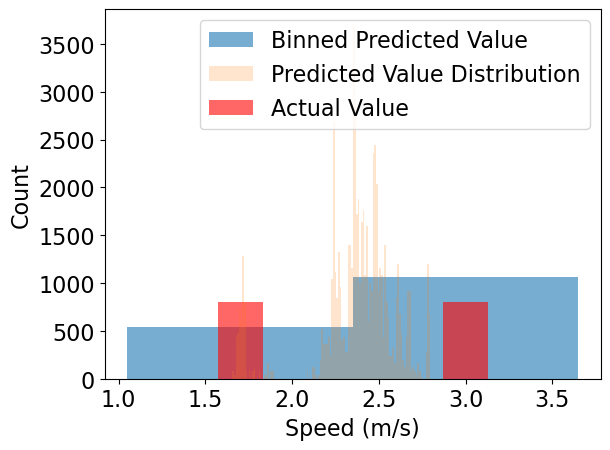

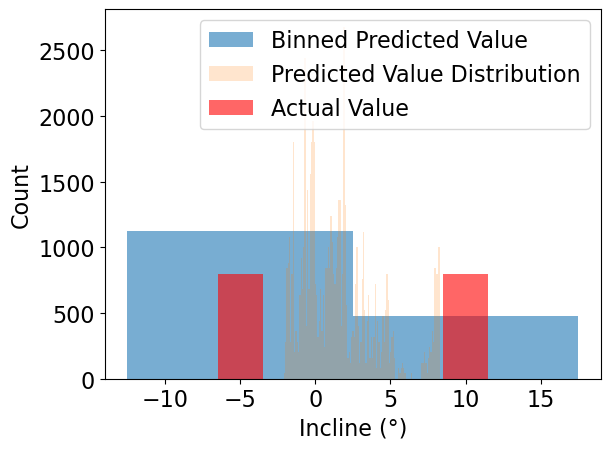

In [5]:
from lisa.modeling.remote_multipredictor import main as multipredictor_main

run_name = 'example'
multipredictor_main(features_path, run_name=run_name, model='LGBM', window=window_size, split=0.8, save=True)

# 5. Analyse Outputs

You'll likely see that the above cell has outputted histograms of the model's speed and incline predictions for the validation dataset. These plots are saved in `models/{run_name}/` along with a confusion matrix of the activity performance, and a `output.json` file recording the evaluation metrics and parameters used in data processing and model tuning.
The model pickle files are also saved here, as a json files recording the model feature importances (for RF and LGBM models).
You may notice that our results show very poor performance - this makes sense, given that the data is completely random!

# 6. Apply Trained Models to New Data
As we've saved our models, we can now load and use them to predict for some new data! Let's create some entirely new c3d files and use the model trained previously to predict activity type.

When this is run, results are recorded in `models/validation/` - a png of the confusion matrix is saved and a row is added to `results.csv`, detailing the evaluation metrics and any related information.

In [ ]:
import shutil

from lisa.config import MODELS_DIR
from lisa.modeling.predict import apply_model

# Create some new data
new_data_dir = synthetic_data_dir / "new_data"
p3_dir = new_data_dir / "P3"
p3_dir.mkdir(parents=True, exist_ok=True)
create_synthetic_c3d_file(p3_dir / "P3_Walk_1_1ms_5Incline.c3d")
create_synthetic_c3d_file(p3_dir / "P3_Run_3_0ms.c3d")

# Process the new data
p3_processed_data = process_files(new_data_dir)
p3_features_path = processed_data_dir / "p3_features.parquet"
feature_extraction(p3_processed_data.collect(), p3_features_path, period=window_size, validate_schema=False)

# Apply the model to the new data
model_path = MODELS_DIR / run_name / 'activity.pkl'
apply_model(p3_features_path, 'ACTIVITY', model_path)

# Delete the 'new_data' directory
shutil.rmtree(new_data_dir)

Processing Participants:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-18 12:11:42.431 | INFO     | lisa.dataset:process_files:242 - Processing participant: P3


Processing Participants: 100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


2025-02-18 12:11:42.458 | INFO     | lisa.dataset:process_files:294 - Processed participant: P3


Processing Trial Groups: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]

2025-02-18 12:11:42.485 | SUCCESS  | lisa.features:feature_extraction:368 - All 1 parts processed and saved to processed_data/p3_features.parquet.
2025-02-18 12:11:42.486 | INFO     | lisa.modeling.predict:apply_model:28 - Loading model from /Users/tomwilson/code/LISA/models/example/activity.pkl
2025-02-18 12:11:42.495 | INFO     | lisa.modeling.predict:apply_model:35 - Loading features from processed_data/p3_features.parquet
2025-02-18 12:11:42.500 | INFO     | lisa.modeling.predict:apply_model:55 - Performing predictions
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5